In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()

# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# 1. 홈 디렉토리에 datasets 폴더 생성 후, 그 안에 cats_and_dogs_small 폴더를 생성 합니다.
# 2. cats_and_dogs_small 안에 train, test, validation 폴더가 위치 하도록 압축을 풉니다.
cd gdrive/My Drive/datasets/cats_and_dogs_small

/content/gdrive/My Drive/datasets/cats_and_dogs_small


In [4]:
!ls

MyInceptionNet.h5   test	       train
newvgg_catsdogs.h5  ThumbDB_190312.db  validation


In [4]:
!!pwd

/content/gdrive/My Drive/datasets/cats_and_dogs_small


In [12]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = '/content/gdrive/My Drive/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 224 × 224 크기로 바꿉니다
        target_size=(224, 224),
        batch_size=4,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=4,
        class_mode='categorical')


Found 2000 images belonging to 2 classes.
Found 1206 images belonging to 2 classes.


In [13]:
for data_batch, labels_batch in train_generator:
    print ('Batch size:', data_batch.shape)
    print ('Label size:', labels_batch.shape)
    break

Batch size: (4, 224, 224, 3)
Label size: (4, 2)


In [8]:
print (train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [9]:
#  This code cell shows how to utilize VGG16 model by combining Dense layer at the end of the network 
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras import layers
from keras import models

VGGNet = VGG16()
VGGNet.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 16s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 11

In [16]:
# We will not update VGG pre-trained model, only added Dense layers will be trained from the scratch
for layer in VGGNet.layers:
  layer.trainable = False
  
Feature_Flatten = VGGNet.get_layer('flatten').output

dense = Dense(256, name='encoding', activation='relu',)(Feature_Flatten)
predictions = Dense(2, activation='softmax', name="prediction")(dense)

New_VGGmodel = Model(inputs=VGGNet.input, outputs=predictions)
New_VGGmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

New_VGGmodel.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [18]:
history = New_VGGmodel.fit_generator(
    train_generator,
    # validation_data=validation_generator, 
    # validation_steps=5,
    # 20장 / batch_size 4 = 5
    steps_per_epoch=15,
    # 60장 / batch_size 4 = 15
    epochs=5
    # 전체 반복 횟수 입니다.
)

Epoch 1/5
15/15 [==============================] - 29s 2s/step - loss: 2.0801 - accuracy: 0.6167
Epoch 2/5
15/15 [==============================] - 28s 2s/step - loss: 1.7191 - accuracy: 0.5833
Epoch 3/5
15/15 [==============================] - 34s 2s/step - loss: 1.3558 - accuracy: 0.7500
Epoch 4/5
15/15 [==============================] - 32s 2s/step - loss: 1.5712 - accuracy: 0.7167
Epoch 5/5
15/15 [==============================] - 26s 2s/step - loss: 1.3396 - accuracy: 0.6000


In [0]:
print (train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [19]:
pip install flickrapi

     |████████████████████████████████| 61kB 6.5MB/s 


In [0]:
from flickrapi import FlickrAPI

FLICKER_KEY = '505e8c2b05e8b5aa51766a43fc4bc7a7'
FLICKER_SECRET = '46b3ef2f43b04ac6'

flickr = FlickrAPI(FLICKER_KEY, FLICKER_SECRET, format='parsed-json')
extras='url_s'
cats = flickr.photos.search(text='puppy', per_page=5, extras=extras)
photos = cats['photos']

In [36]:
photos

{'page': 1,
 'pages': 40508,
 'perpage': 5,
 'photo': [{'farm': 66,
   'height_s': 196,
   'id': '49833425466',
   'isfamily': 0,
   'isfriend': 0,
   'ispublic': 1,
   'owner': '30041364@N08',
   'secret': '442f29ce9f',
   'server': '65535',
   'title': 'Brass Britches Brad',
   'url_s': 'https://live.staticflickr.com/65535/49833425466_442f29ce9f_m.jpg',
   'width_s': 240},
  {'farm': 66,
   'height_s': 145,
   'id': '49832849453',
   'isfamily': 0,
   'isfriend': 0,
   'ispublic': 1,
   'owner': '55496244@N02',
   'secret': '6c8db1a0f7',
   'server': '65535',
   'title': 'Henlo Hoomans',
   'url_s': 'https://live.staticflickr.com/65535/49832849453_6c8db1a0f7_m.jpg',
   'width_s': 240},
  {'farm': 66,
   'height_s': 240,
   'id': '49833649712',
   'isfamily': 0,
   'isfriend': 0,
   'ispublic': 1,
   'owner': '188156426@N03',
   'secret': '5787d25cdf',
   'server': '65535',
   'title': "I'm watching you",
   'url_s': 'https://live.staticflickr.com/65535/49833649712_5787d25cdf_m.jpg',


In [0]:
# import the necessary packages
import numpy as np
import urllib
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return image

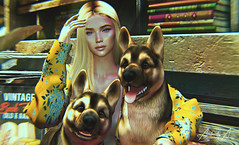

In [39]:
from google.colab.patches import cv2_imshow

image_original_url = photos['photo'][1]['url_s']

image_temp = url_to_image(image_original_url)
cv2_imshow(image_temp)

In [40]:
# 4D-tensor(B, H, W, C) -> (1, 224, 224, 3)
image_temp.shape

(145, 239, 3)

In [41]:
resized_image = cv2.resize(image_temp, (224, 224))
print (resized_image.shape)

(224, 224, 3)


In [42]:
resized_image = np.expand_dims(resized_image, axis=0)
print (resized_image.shape)

(1, 224, 224, 3)


In [0]:
result = New_VGGmodel.predict(resized_image)

In [44]:
result

array([[0., 1.]], dtype=float32)

In [45]:
np.argmax(result)

1

In [0]:
!pwd

/content/gdrive/My Drive/datasets/cats_and_dogs_small


In [0]:
New_VGGmodel.save('newvgg_catsdogs.h5')

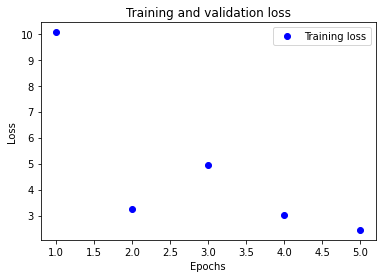

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()